In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
df = pd.read_excel("NFHS_5_Factsheets_Data.xls")

In [3]:

df =df[['States/UTs','Area','Average out-of-pocket expenditure per delivery in a public health facility (for last birth in the 5 years before the survey) (Rs.)']]
df =df[df.Area=='Total']
df = df.drop(columns=["Area"])
df.columns = ['states', 'delivery_cost']

In [4]:
df.head()

,states,delivery_cost
2,India,2915.87
5,Andaman & Nicobar Islands,2924.19
8,Andhra Pradesh,3105.47
11,Arunachal Pradesh,9731.31
14,Assam,5415.26


In [5]:
state_name_map = {
    'Andaman & Nicobar Islands': 'Andaman & Nicobar',
    'Dadra and Nagar Haveli & Daman and Diu': 'DNHDD',  # prioritize one; see note below
    'NCT of Delhi': 'Delhi',
    'Maharastra': 'Maharashtra'

}
df['states'] = df['states'].replace(state_name_map)


In [6]:
gdf = gpd.read_file("INDIA_STATES.geojson")

# Replace STNAME values to merge
gdf['STNAME_SH'] = gdf['STNAME_SH'].replace({
    'Dadra & Nagar Haveli': 'Daman & Diu'
    
})

# Dissolve rows with same state name into a single geometry
gdf = gdf.dissolve(by='STNAME_SH', as_index=False)
gdf['STNAME_SH'] = gdf['STNAME_SH'].replace('Daman & Diu', 'DNHDD')




In [7]:
# merge dataframes on state names
final = gdf.merge(df, left_on='STNAME_SH', right_on='states')


In [8]:
final.columns

Index(['STNAME_SH', 'geometry', 'STNAME', 'STCODE11', 'Shape_Length',
       'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng',
       'MaxSimpTol', 'MinSimpTol', 'states', 'delivery_cost'],
      dtype='object')

In [9]:
final['delivery_cost'] = pd.to_numeric(final['delivery_cost'], errors='coerce')



In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

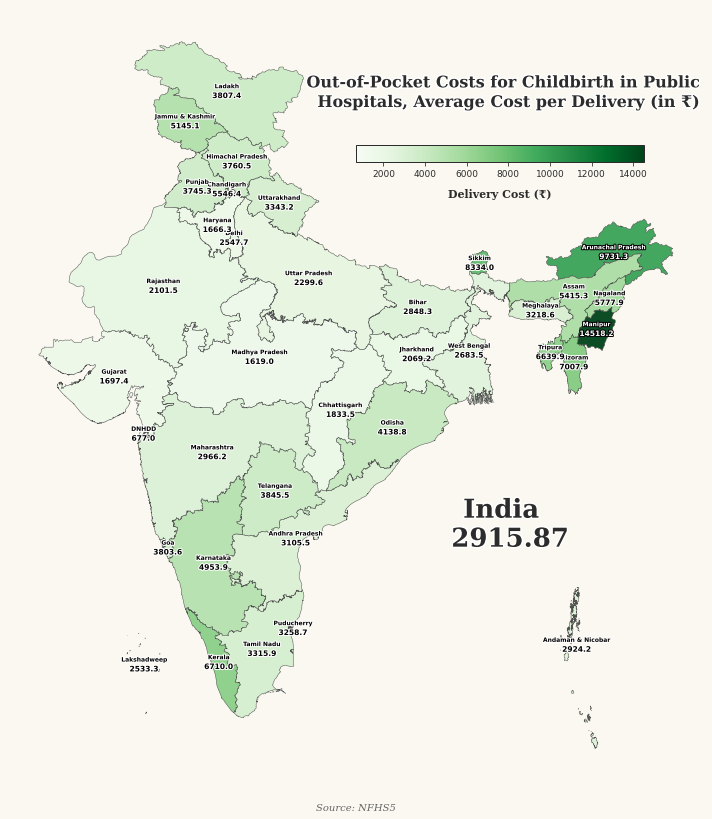

In [16]:
def create_delivery_cost_map(final_df):
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')

    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    # Use a green colormap
    cmap = plt.cm.Greens
    min_val = final_df['delivery_cost'].replace(0, np.nan).min()
    max_val = final_df['delivery_cost'].max()
    norm = Normalize(vmin=min_val, vmax=max_val)

    def get_color_for_value(value):
        if pd.isnull(value) or value == 0:
            return (0.85, 0.85, 0.85, 1.0)  # grey for 0 or missing
        return cmap(norm(value))

    colors = final_df['delivery_cost'].apply(get_color_for_value)

    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='#4a4a4a',
        linewidth=0.5,
        alpha=0.95
    )

    def get_text_color(value):
        if pd.isnull(value) or value == 0:
            return 'black'
        return 'white' if value > (max_val * 0.6) else 'black'

    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            value = row['delivery_cost']
            text_color = get_text_color(value)
            outline_color = 'black' if text_color == 'white' else 'white'

            ax_map.text(
                point.x, point.y + 0.2, row['STNAME_SH'],
                ha='center', va='center', fontsize=6, fontweight='bold',
                color=text_color, 
                path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
            )

            if pd.notnull(value) and value != 0:
                ax_map.text(
                    point.x, point.y - 0.2, f"{value:.1f}",
                    ha='center', va='center', fontsize=7.5, fontweight='bold',
                    color=text_color,
                    path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
                )

    ax_map.set_title(
        '', fontsize=24, fontweight='bold', fontfamily='serif',
        pad=30, color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )
    ax_map.set_axis_off()

    # Continuous colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar_ax = fig.add_axes([0.50, 0.77, 0.25, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=9, colors='#2c2c2c', length=4)
    cbar.set_label('Delivery Cost (₹)', fontsize=11, fontweight='bold',
                   color='#2c2c2c', labelpad=10, fontfamily='serif')
    cbar.outline.set_edgecolor('#2c2c2c')
    cbar.outline.set_linewidth(1)

    # Annotation above colorbar (edit this if needed)
    fig.text(
        0.63, 0.85,
        'Out-of-Pocket Costs for Childbirth in Public \n Hospitals, Average Cost per Delivery (in ₹)',
        ha='center', va='center',
        fontsize=16, fontweight='bold', fontfamily='serif', color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    fig.text(
        0.63, 0.35,
        'India \n 2915.87',
        ha='center', va='center',
        fontsize=26, fontweight='bold', fontfamily='serif', color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    plt.figtext(
        0.5, 0.02, 'Source: NFHS5',
        ha='center', fontsize=10, color='#666666', style='italic', fontfamily='serif'
    )

    ax_map.grid(True, alpha=0.1, color='gray', linewidth=0.5)
    plt.tight_layout()
    return fig

# === Execution ===
if __name__ == "__main__":
    map_fig = create_delivery_cost_map(final)

    map_fig.savefig('delivery_cost_map.png', dpi=300, bbox_inches='tight',
                    facecolor=map_fig.get_facecolor(), edgecolor='none')
    map_fig.savefig('delivery_cost_map.pdf', bbox_inches='tight',
                    facecolor=map_fig.get_facecolor(), edgecolor='none')

    plt.show()


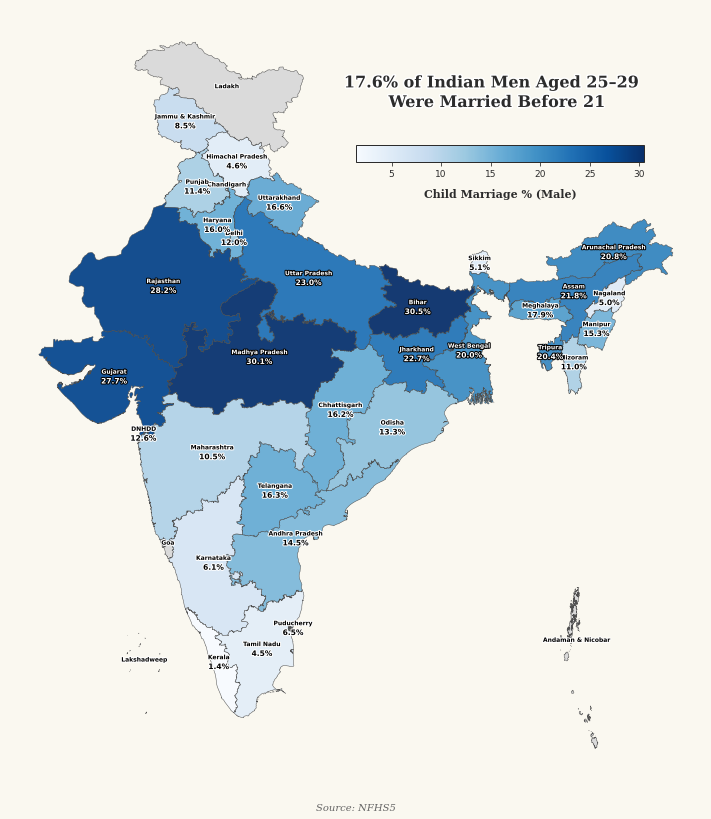

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects

def create_child_marriage_map(final_df):
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#faf8f0')

    ax_map = plt.axes([0.05, 0.05, 0.9, 0.9])
    ax_map.set_facecolor('#faf8f0')

    cmap = plt.cm.Blues  # Switched to blue colormap
    min_val = final_df['male_mar'].replace(0, np.nan).min()
    max_val = final_df['male_mar'].max()
    norm = Normalize(vmin=min_val, vmax=max_val)

    def get_color_for_value(value):
        if pd.isnull(value) or value == 0:
            return (0.85, 0.85, 0.85, 1.0)  # grey for 0 or missing
        return cmap(norm(value))

    colors = final_df['male_mar'].apply(get_color_for_value)

    final_df.plot(
        ax=ax_map,
        color=colors.tolist(),
        edgecolor='#4a4a4a',
        linewidth=0.5,
        alpha=0.95
    )

    def get_text_color(value):
        if pd.isnull(value) or value == 0:
            return 'black'
        return 'white' if value > (max_val * 0.6) else 'black'

    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            value = row['male_mar']
            text_color = get_text_color(value)
            outline_color = 'black' if text_color == 'white' else 'white'

            ax_map.text(
                point.x, point.y + 0.2, row['STNAME_SH'],
                ha='center', va='center', fontsize=6, fontweight='bold',
                color=text_color,
                path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
            )

            if pd.notnull(value) and value != 0:
                ax_map.text(
                    point.x, point.y - 0.2, f"{value:.1f}%",
                    ha='center', va='center', fontsize=7.5, fontweight='bold',
                    color=text_color,
                    path_effects=[path_effects.withStroke(linewidth=2, foreground=outline_color)]
                )

    ax_map.set_title(
        '', fontsize=24, fontweight='bold', fontfamily='serif',
        pad=30, color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )
    ax_map.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar_ax = fig.add_axes([0.50, 0.77, 0.25, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=9, colors='#2c2c2c', length=4)
    cbar.set_label('Child Marriage % (Male)', fontsize=11, fontweight='bold',
                   color='#2c2c2c', labelpad=10, fontfamily='serif')
    cbar.outline.set_edgecolor('#2c2c2c')
    cbar.outline.set_linewidth(1)

    fig.text(
        0.62, 0.85,
        '17.6% of Indian Men Aged 25–29 \n Were Married Before 21',
        ha='center', va='center',
        fontsize=16, fontweight='bold', fontfamily='serif', color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    fig.text(
        0.63, 0.85, '',
        ha='center', va='center',
        fontsize=16, fontweight='bold', fontfamily='serif', color='#2c2c2c',
        path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
    )

    plt.figtext(
        0.5, 0.02, 'Source: NFHS5',
        ha='center', fontsize=10, color='#666666', style='italic', fontfamily='serif'
    )

    ax_map.grid(True, alpha=0.1, color='gray', linewidth=0.5)
    plt.tight_layout()
    return fig

# === Execution ===
if __name__ == "__main__":
    map_fig = create_child_marriage_map(final)

    map_fig.savefig('child_marriage_male_map.png', dpi=300, bbox_inches='tight',
                    facecolor=map_fig.get_facecolor(), edgecolor='none')
    map_fig.savefig('child_marriage_male_map.pdf', bbox_inches='tight',
                    facecolor=map_fig.get_facecolor(), edgecolor='none')

    plt.show()
